https://github.com/OctThe16th/PPO-Keras

https://github.com/hill-a/stable-baselines

https://github.com/rlcode/reinforcement-learning

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model, clone_model
from keras.optimizers import Adam
from keras import backend as K 

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

LOSS_CLIPPING = 0.2
ENTROPY_LOSS = 1e-3

def proximal_policy_optimization_loss(advantage, old_prediction):
    def loss(y_true, y_pred):
        prob = y_true * y_pred
        old_prob = y_true * old_prediction
        r = prob/(old_prob + 1e-10)
        return -K.mean(K.minimum(r * advantage, K.clip(r, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantage) + ENTROPY_LOSS * (prob * K.log(prob + 1e-10)))
    return loss

In [18]:
class Environment:
    def __init__(self, verbose=False):
        self.n_actions = 3
        self.n_obs = 2
        self.verbose = verbose
        self.space = np.sin(np.linspace(0,2*np.pi,20))
        
    def reset(self):
        self.x = 0
        self.target = self.space[self.x]
        self.agent = self.space[self.x]
        self.state = [self.target, self.agent]
        
        self.x_data = []
        self.target_data = []
        self.agent_data = []
        return self.state
    
    def step(self, action):
        self.x += 1
        self.target = self.space[self.x]
        if action == 0:
            pass
        if action == 1:
            self.agent += 0.25
        if action == 2:
            self.agent -= 0.25
            
        self.state = [self.target, self.agent]
        
        dist = abs(self.target - self.agent)
        reward = 0
        if dist < 0.25:
            reward = 1.
        if dist > 0.5:
            reward = -1.
            
        done = False
        if self.x >= 19:
            done = True
            
        self.x_data.append(self.x)
        self.target_data.append(self.target)
        self.agent_data.append(self.agent)
            
        return self.state, reward, done, {}
    
    def render(self):
        plt.plot(self.x_data, self.target_data, '.')
        plt.plot(self.x_data, self.agent_data, '.')
        plt.show()

In [19]:
class Agent:
    def __init__(self, n_obs=2, n_actions=3, ppo=True, verbose=False):
        K.clear_session()
        self.ppo = ppo
        self.n_obs = n_obs
        self.n_actions = n_actions
        self.iter = 0
        self.verbose = verbose
        
        self.discount_factor = 0.99
        self.epsilon = 0.2
        self.actor_lr = 0.001
        self.critic_lr = 0.005
        self.hidden_size = 128
        
        self.actor = self.build_actor() 
        self.critic = self.build_critic()
    
    def build_actor(self):
        state_inputs = Input(shape=(self.n_obs,))
        advantage = Input(shape=(1,))
        old_prediction = Input(shape=(self.n_actions,))
        
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        out_actions = Dense(self.n_actions, activation='softmax')(x)

        model = Model(inputs=[state_inputs, advantage, old_prediction],
                      outputs=[out_actions])
        
        model.compile(optimizer=Adam(lr=self.actor_lr),
                      loss=[proximal_policy_optimization_loss(
                          advantage=advantage,
                          old_prediction=old_prediction)])
        return model
    
    def build_critic(self):
        state_inputs = Input(shape=(self.n_obs,))
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        predictions = Dense(1, activation='linear')(x)

        model = Model(inputs=state_inputs, outputs=predictions)
        model.compile(optimizer=Adam(lr=self.critic_lr),
                      loss='mse')
        return model
    
    def get_action(self, state):
        # Predict the probability destribution of the actions as a vactor
        prob = self.actor.predict(state, batch_size=1).flatten()
        
        # Sample an action as a scaler
        action = np.random.choice(self.n_actions, 1, p=prob)[0]
        
        # Vectorize the action as a one-hot encoding
        action_vector = np.zeros(self.n_actions)
        action_vector[action] = 1
        
        return action, action_vector, prob
    
    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, 1))
        advantages = np.zeros((1, self.n_actions))
        
        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]
        
        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value
            
        if self.ppo:
            r = self.get_r(state)
            loss = np.minimum(r*advantages[0],
                              np.clip(r, 1-self.epsilon, 1+self.epsilon) * advantages[0])
            loss = np.array([loss])
            self.actor.fit(state, loss, epochs=1, verbose=0)
            self.critic.fit(state, target, epochs=1, verbose=0)
        else:
            self.actor.fit(state, advantages, epochs=1, verbose=0)
            self.critic.fit(state, target, epochs=1, verbose=0)
            
        if self.verbose:
            print('-'*20)
            print('Adv: ', advantages[0])
            print('Norm:', softmax(advantages[0]))
            print()
            print('r:', r)
            print('A:', advantages[0])
            print('r*A:', r*advantages[0])
            print()
    
    def train_model_ppo(self, state, action, reward, next_state, done):
        target = np.zeros((1, 1))
        advantages = np.zeros((1, self.n_actions))
        
        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]
        
        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value
            
        if self.ppo:
            r = self.get_r(state)
            loss = np.minimum(r*advantages[0],
                              np.clip(r, 1-self.epsilon, 1+self.epsilon) * advantages[0])
            loss = np.array([loss])
            self.actor.fit(state, loss, epochs=1, verbose=0)
            self.critic.fit(state, target, epochs=1, verbose=0)
        else:
            self.actor.fit(state, advantages, epochs=1, verbose=0)
            self.critic.fit(state, target, epochs=1, verbose=0)
            
        if self.verbose:
            print('-'*20)
            print('Adv: ', advantages[0])
            print('Norm:', softmax(advantages[0]))
            print()
            print('r:', r)
            print('A:', advantages[0])
            print('r*A:', r*advantages[0])
            print()
            
    
    def train_batch(self, observations, actions, probabilities, rewards):
        obs = observations[:buffer_size]
        acts = actions[:buffer_size]
        probs = probabilities[:buffer_size]
        rews = rewards[:buffer_size]
        old_probs = probabilities
        
        values = self.critic.predict(obs)
        advs = rews - values # advantages
            
        self.actor.fit([obs, advs, old_probs], [acts],
                       batch_size=batch_size, shuffle=True, epochs=epochs, verbose=False)
        self.critic.fit([obs], [rews],
                       batch_size=batch_size, shuffle=True, epochs=epochs, verbose=False)

In [20]:
agent = Agent(ppo=True)
env = Environment()

In [24]:
log_interval = 100
buffer_size = 256
batch_size = 64
gamma = 0.99
epochs = 10
train_on_batch = False

observation = env.reset()
sampled_rewards = []

# Collect a batch of samples
for episode in range(1001):
    #state = np.reshape(state, (1, env.n_obs))
    
    batch = {
        'observation': [],
        'action_vector': [],
        'probability': [],
        'reward': []
    }
    
    tmp_batch = {
        'observation': [],
        'action_vector': [],
        'probability': []
    }
    
    while len(batch['observation']) < buffer_size:
        action, action_vector, prob = agent.get_action(observation)
        next_observation, reward, done, info = env.step(action)
        # observation = np.reshape(observation, (1, env.n_obs))

        sampled_rewards.append(reward)
        
        tmp_batch['observation'].append(observation)
        tmp_batch['action_vector'].append(action_vector)
        tmp_batch['probability'].append(prob)
        observation = next_observation

        if done:
            for j in range(len(sampled_rewards) - 2, -1, -1):
                sampled_rewards[j] += sampled_rewards[j + 1] * gamma
                
            if episode % log_interval == 0:
                # Append Temp Batch to Master Batch
                for i in range(len(tmp_batch['observation'])):
                    obs = tmp_batch['observation'][i]
                    act = tmp_batch['action_vector'][i]
                    prob = tmp_batch['probibility'][i]
                    r = sampled_rewards[i]
                    
                    batch['observation'].append(obs)
                    batch['action_vector'].append(act)
                    batch['probibility'].append(prob)
                    batch['reward'].append(r)
                
                # Log and Plot
                print('Episode', episode)
                env.render()
                
                observation = env.reset()
                rewards = []
                
    observations = np.array(batch['observation'])
    actions = np.array(batch['action_vecor'])
    probabilities = np.array(batch['probability'])
    rewards = np.array(batch['reward'])
    
    probabilities = np.reshape(probabilities, (probabilities.shape[0], probabilities.shape[2]))
    rewards = np.reshape(rewards, (len(batch['reward']), 1))
                               
    agent.train_batch(observations, actions, probabilities, rewards)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 3 array(s), but instead got the following list of 2 arrays: [0.0, 0.0]...

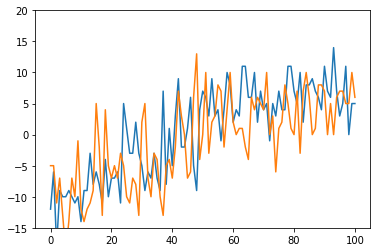

In [15]:
plt.plot(old_rewards)
plt.plot(new_rewards)
plt.ylim((-15, 20))
plt.show()